In [1]:
import os
import pickle
import glob
import random

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn import ensemble, svm
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler

import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import spike_utils, decoding_utils


In [2]:
all_ephys_sessions = tuple(s for s in npc_lims.get_session_info(is_ephys=True, is_uploaded=True, is_annotated=True,))# project='DynamicRouting'))
                            #(s.project=='DynamicRouting'))

c:\Anaconda3\envs\npc_analysis\Lib\site-packages\npc_lims\metadata\codeocean.py:201: UserWarning: There is more than one asset for session = '644866_2023-02-08'. Defaulting to most recent: ('ecephys_644866_2023-02-08_16-01-11', 'ecephys_644866_2023-02-08_16-01-11')
  warnings.warn(
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\npc_lims\metadata\codeocean.py:201: UserWarning: There is more than one asset for session = '664851_2023-11-14'. Defaulting to most recent: ('ecephys_664851_2023-11-14_12-44-33', 'ecephys_664851_2023-11-14_12-44-33')
  warnings.warn(
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\npc_lims\metadata\codeocean.py:201: UserWarning: There is more than one asset for session = '686176_2023-12-06'. Defaulting to most recent: ('ecephys_686176_2023-12-06_13-03-34', 'ecephys_686176_2023-12-06_13-03-34')
  warnings.warn(


In [9]:
# import glob
all_ephys_sessions[17]
# os.path.split(glob.glob(os.path.join(all_ephys_sessions[-8].allen_path,"Behavior_*.mp4"))[0])

SessionInfo(id='686740_2023-10-23', project='DynamicRouting', is_ephys=True, is_sync=True, allen_path=WindowsUPath('//allen/programs/mindscope/workgroups/dynamicrouting/PilotEphys/Task 2 pilot/DRpilot_686740_20231023'), experiment_day=1, session_kwargs={}, notes='', issues=[])

In [7]:
#convert load facemap to use data on s3
#or at least add an option to do so
# session=all_ephys_sessions[0]
# behav_info = np.load(
#             npc_lims.get_cache_path('facemap',session.id,version='any'),
#             allow_pickle=True
#         )
session=DynamicRoutingSession(all_ephys_sessions[0])
X=session._facemap_face_output

c:\Anaconda3\envs\npc_analysis\Lib\site-packages\pynwb\base.py:193: UserWarning: TimeSeries 'Facemap Behavior Proc Output': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "


In [10]:
X

Facemap Behavior Proc Output pynwb.base.TimeSeries at 0x2114263093328
Fields:
  comments: no comments
  conversion: 1.0
  data: (
    [],
    [[-240.36627      87.91644    -112.95393    ...    1.2362213
     0.31949615    0.7431145 ]
 [-240.36627      87.91644    -112.95393    ...    1.2362213
     0.31949615    0.7431145 ]
 [-173.37273     -71.2024        7.4035254  ...    4.853175
    -2.7335627    -0.25878707]
 ...
 [ -50.632866     59.902767     84.93916    ...   -1.0510504
    -4.3209944    -1.1825297 ]
 [  35.611534    -40.72782     158.99353    ...   -3.1724272
     2.7279055    -4.2445292 ]
 [  36.8212        1.9601312    94.2237     ...   -0.30582383
     7.3080015   -16.02786   ]]
  )
  description: Motion SVD for behavior video. Shape is number of frames by number of components (500)
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: [       nan   14.1186    14.13527 ... 7208.4503  7208.46697 7208.48364]
  timestamps_unit: seconds
  unit: pixels

In [4]:
def load_facemap_data(session,session_info,vid_angle,keep_n_SVDs=500,use_s3=True):

    vid_angle_npc_names={
            'behavior':'side',
            'face':'front',
            'eye':'eye',
            }
    
    # path=os.path.join(session_info.allen_path,'processed')

    if use_s3==False:
        if vid_angle=='behavior':
            multi_ROI_path=r"D:\DR Pilot Data\full_video_multi_ROI"
            _dir,vidfilename=os.path.split(glob.glob(os.path.join(session_info.allen_path,"Behavior_*.mp4"))[0])
        elif vid_angle=='face':
            multi_ROI_path=r"D:\DR Pilot Data\full_video_multi_ROI_face"
            _dir,vidfilename=os.path.split(glob.glob(os.path.join(session_info.allen_path,"Face_*.mp4"))[0])

        behav_path = os.path.join(multi_ROI_path,vidfilename[:-4]+'_trimmed_proc.npy')
        behav_info=np.load(behav_path,allow_pickle=True)

        for frame_time in session._video_frame_times:
            if vid_angle_npc_names[vid_angle] in frame_time.name:
                cam_frames=frame_time.timestamps
                break

        facemap_info={}

        #actually keep all ROIs
        facemap_info['motion']=behav_info.item()['motion']
        facemap_info['motSVD']=behav_info.item()['motSVD']
    #use s3 data
    else:
        behav_info = np.load(
            npc_lims.get_cache_path('facemap',session.id,version='any'),
            allow_pickle=True
        )
        behav_info = behav_info.item()
        cam_frames = behav_info['cam_frames']

        facemap_info = {
            'motion': behav_info['motion'],
            'motSVD': behav_info['motSVD']
        }


    #calculate mean face motion, SVD in 1 sec prior to each trial
    # 1 sec before stimulus onset
    time_before=0.2
    time_after=0
    fps=60

    behav_SVD_by_trial={}
    behav_motion_by_trial={}
    mean_trial_behav_SVD={}
    mean_trial_behav_motion={}

    trials=pd.read_parquet(
                npc_lims.get_cache_path('trials',session.id,version='any')
            )

    for rr in range(0,len(behav_info.item()['motSVD'])):
        behav_SVD_by_trial[rr] = np.zeros((int((time_before+time_after)*fps),keep_n_SVDs,len(trials)))
        behav_motion_by_trial[rr] = np.zeros((int((time_before+time_after)*fps),len(trials)))

        behav_SVD_by_trial[rr][:]=np.nan
        behav_motion_by_trial[rr][:]=np.nan

        for tt,stimStartTime in enumerate(trials[:]['stim_start_time']):
            if len(np.where(cam_frames>=stimStartTime)[0])>0:
                stim_start_frame=np.where(cam_frames>=stimStartTime)[0][0]
                trial_start_frame=int(stim_start_frame-time_before*fps)
                trial_end_frame=int(stim_start_frame+time_after*fps)

                behav_SVD_by_trial[rr][:,:,tt] = facemap_info['motSVD'][rr][trial_start_frame:trial_end_frame,:keep_n_SVDs]    
                behav_motion_by_trial[rr][:,tt] = facemap_info['motion'][rr][trial_start_frame:trial_end_frame]

        mean_trial_behav_SVD[rr] = np.nanmean(behav_SVD_by_trial[rr],axis=0)
        mean_trial_behav_motion[rr] = np.nanmean(behav_motion_by_trial[rr],axis=0)

    return mean_trial_behav_SVD, mean_trial_behav_motion

In [13]:
##TODO:
# change structure to not use block_multiplier variable as much
# functionize more

#set params
savepath=r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\multi_shuffled_blocks_facemap"
filename="multi_shuffled_blocks_facemap.pkl"

all_areas=True
single_area=None
n_block_repeats=100
n_repeats=1
balance_labels_overall=False #balances number of samples per condition for input into decoder function
trnum='all'
u_min=20
n_units=['all']
crossval='5_fold'

input_data_type='facemap' #spikes or facemap
vid_angle='behavior' #behavior, face, eye

block_shuffle_type='subblocks' #variable or subblocks or exponential

if (block_shuffle_type=='exponential')|(block_shuffle_type=='uniform'):
    block_multipliers=[1]
elif block_shuffle_type=='variable':
    block_multipliers=[1,2,3]
elif block_shuffle_type=='subblocks':
    block_multipliers=[1,2,3,4,5,10]

#define block lengths and varability
block_duration_means=[300,400,600] #seconds
block_duration_stds=[30,90,150]
block_duration_min=100
block_duration_max=1000

# block_duration_mean=600 #seconds
# block_duration_std=150
# block_duration_min=200
# block_duration_max=1000

exp_block_duration_mean=150
exp_block_duration_min=300
exp_block_duration_max=900
task_duration_min=3600

spikes_binsize=0.1
spikes_time_before=0.5
spikes_time_after=0.5

decoder_binsize=0.2
decoder_time_before=0.2
decoder_time_after=0.1

time_bins = np.arange(-decoder_time_before,decoder_time_after,decoder_binsize)

except_list={}

#loop through sessions
for sel_session in all_ephys_sessions[16:18]:
    
    # try:
        # load data
        session=DynamicRoutingSession(sel_session)
        session_info=npc_lims.get_session_info(sel_session)
        trials=pd.read_parquet(
                    npc_lims.get_cache_path('trials',session.id,version='any')
                )

        if input_data_type=='spikes':
            #make data array
            units=pd.read_parquet(
                        npc_lims.get_cache_path('units',session.id,version='any')
                    )
            trial_da = spike_utils.make_neuron_time_trials_tensor(units, trials, spikes_time_before, spikes_time_after, spikes_binsize)
        elif input_data_type=='facemap':
            mean_trial_behav_SVD,mean_trial_behav_motion = load_facemap_data(session,session_info,vid_angle)

        # get input data for decoder
        structure_probe=spike_utils.get_structure_probe(session)
        area_counts=structure_probe['structure_probe'].value_counts()

        # predict=['stim_ids','block_ids','trial_response']
        predict=['block_ids']

        if 'opto_power' in trials[:].columns:
            trial_sel = trials[:].query('opto_power.isnull() and trial_index_in_block>=5').index
        else:
            trial_sel = trials[:].index

        block_context_names=np.array(['vis','aud'])
        start_time=trials[:]['start_time'].iloc[0]

        svc_results={
            'session_info' : session_info,
        }
        
        #loop through block multipliers
        for block_multiplier in block_multipliers:
        # block_multiplier=5
            svc_results[block_multiplier]={}

            context=np.full(len(trials[:]), fill_value='nan')
            block_nums=np.full(len(trials[:]), fill_value=np.nan)

            # make "real" subdivided blocks
            if session_info.project=='TempletonPilotSession':    
                if np.random.choice(block_context_names,1)=='vis':
                    block_context_index=([0]*block_multiplier+[1]*block_multiplier)*3
                else:
                    block_context_index=([1]*block_multiplier+[0]*block_multiplier)*3
                block_contexts=block_context_names[block_context_index]
                for block in range(0,6*block_multiplier):
                    block_start_time=start_time+block*(10/block_multiplier)*60
                    block_end_time=start_time+(block+1)*(10/block_multiplier)*60
                    block_trials=trials[:].query('start_time>=@block_start_time').index
                    context[block_trials]=block_contexts[block]
                    block_nums[block_trials]=block
                block_index=block_nums[trial_sel]
                pred_var=context[trial_sel]
                
            elif session_info.project=='DynamicRouting':
                if trials[:]['context_name'].iloc[0]=='vis':
                    block_context_index=([0]*block_multiplier+[1]*block_multiplier)*3
                elif trials[:]['context_name'].iloc[0]=='aud':
                    block_context_index=([1]*block_multiplier+[0]*block_multiplier)*3
                block_contexts=block_context_names[block_context_index]
                for block in range(0,6*block_multiplier):
                    block_start_time=start_time+block*(10/block_multiplier)*60
                    block_end_time=start_time+(block+1)*(10/block_multiplier)*60
                    block_trials=trials[:].query('start_time>=@block_start_time').index
                    context[block_trials]=block_contexts[block]
                    block_nums[block_trials]=block
                block_index=block_nums[trial_sel]
                pred_var=context[trial_sel]
                # pred_var = trials[:]['context_name'][trial_sel].values

            #make psuedo blocks
            start_time=trials[:]['start_time'].iloc[0]
            block_index_pseudo=[]
            pred_var_pseudo=[]

            if block_shuffle_type=='subblocks':
                blocks=np.array([0,1]*3*block_multiplier)
                
                for nn in range(0,n_block_repeats):
                    fake_context=np.full(len(trials[:]), fill_value='nan')
                    fake_block_nums=np.full(len(trials[:]), fill_value=np.nan)
                    block_contexts=np.random.choice(blocks,len(blocks),replace=False)
                    for block in range(0,6*block_multiplier):
                        block_start_time=start_time+block*(10/block_multiplier)*60
                        block_end_time=start_time+(block+1)*(10/block_multiplier)*60
                        block_trials=trials[:].query('start_time>=@block_start_time').index
                        fake_context[block_trials]=block_context_names[block_contexts[block]]
                        fake_block_nums[block_trials]=block
                    block_index_pseudo.append(fake_block_nums[trial_sel])
                    pred_var_pseudo.append(fake_context[trial_sel])

            elif block_shuffle_type=='variable':
                
                block_duration_mean=block_duration_means[block_multiplier]
                block_duration_std=block_duration_stds[block_multiplier]
                
                blocks=np.array([0,1]*3)

                n_repeats_per_session=3 #draw 3 block lengths plus their counterparts

                for nn in range(0,n_block_repeats):
                    fake_context=np.full(len(trials[:]), fill_value='nan')
                    fake_block_nums=np.full(len(trials[:]), fill_value=np.nan)
                    block_lengths=[]
                    #draw block lengths for this repeat
                    for ii in range(0,n_repeats_per_session):
                        append=False
                        while append==False:
                            s = np.random.default_rng().normal(block_duration_mean, block_duration_std, 1)
                            t = block_duration_mean + block_duration_std-s
                            if s>=block_duration_min and s<=block_duration_max and t>=block_duration_min and t<=block_duration_max:
                                append=True
                        block_lengths.append(s)
                        block_lengths.append(t)
                    block_lengths=np.hstack(block_lengths)
                    block_lengths=np.random.choice(block_lengths,len(block_lengths),replace=False)
                    block_lengths=np.hstack([0,block_lengths])
                    block_lengths=np.cumsum(block_lengths)
                    #get trial labels according to block lengths
                    block_contexts=np.random.choice(blocks,len(blocks),replace=False)
                    for block in range(0,6):
                        block_start_time=start_time+block_lengths[block]
                        # if block<5:
                        #     block_end_time=start_time+(block_lengths[block+1])
                        # if block==5:
                        #     block_end_time=trials[:]['end_time'].iloc[-1]
                        block_trials=trials[:].query('start_time>=@block_start_time').index
                        fake_context[block_trials]=block_context_names[block_contexts[block]]
                        fake_block_nums[block_trials]=block

                    block_index_pseudo.append(fake_block_nums[trial_sel])
                    pred_var_pseudo.append(fake_context[trial_sel])

            elif (block_shuffle_type=='exponential') | (block_shuffle_type=='uniform'):
                
                all_block_index_psuedo=[]
                all_block_lengths_pseudo=[]
                all_block_contexts_pseudo=[]

                block_index_pseudo=[]
                pred_var_pseudo=[]

                for nn in range(0,n_block_repeats):
                    current_context=np.random.choice([0,1],1,replace=False)
                    fake_context=np.full(len(trials[:]), fill_value='nan')
                    fake_block_nums=np.full(len(trials[:]), fill_value=np.nan)
                    # =block_context
                    total_time=0
                    current_block_index=0
                    block_lengths=[]
                    block_contexts=[]
                    block_index=[]

                    while total_time<=3600:
                        if block_shuffle_type=='exponential':
                            rando_block_length=random.expovariate(1/exp_block_duration_mean)+exp_block_duration_min
                        elif block_shuffle_type=='uniform':
                            rando_block_length=random.uniform(exp_block_duration_min,exp_block_duration_max)
                        if rando_block_length>exp_block_duration_max:
                            rando_block_length=exp_block_duration_max

                        if current_context==0:
                            current_context=1
                        elif current_context==1:
                            current_context=0
                        
                        block_lengths.append(rando_block_length)
                        block_contexts.append(current_context)
                        block_index.append(current_block_index)
                        current_block_index+=1
                        total_time+=rando_block_length

                    all_block_lengths_pseudo.append(np.hstack(block_lengths))
                    all_block_contexts_pseudo.append(np.hstack(block_contexts))
                    all_block_index_psuedo.append(np.hstack(block_index))

                    #apply to trials
                    for block in range(0,len(block_lengths)):
                        block_start_time=start_time+np.sum(block_lengths[:block])
                        if block_start_time<=trials[:]['start_time'].iloc[-1]:
                            block_trials=trials[:].query('start_time>=@block_start_time').index
                            fake_context[block_trials]=block_context_names[block_contexts[block]]
                            fake_block_nums[block_trials]=block

                    block_index_pseudo.append(fake_block_nums[trial_sel])
                    pred_var_pseudo.append(fake_context[trial_sel])

            elif block_shuffle_type=='linear_shift':
                all_block_index_psuedo=[]
                all_block_lengths_pseudo=[]
                all_block_contexts_pseudo=[]

                #take middle 4 blocks, incrementally shift them by 1 trial
                

            svc_results[block_multiplier]['block_index']=block_index
            svc_results[block_multiplier]['pred_var']=pred_var
            svc_results[block_multiplier]['block_index_pseudo']=block_index_pseudo
            svc_results[block_multiplier]['pred_var_pseudo']=pred_var_pseudo
            
            if input_data_type=='spikes':
                if all_areas == False:
                    area_sel = [single_area]
                else:
                    area_sel = ['all']+list(area_counts[area_counts>=u_min].index)
            elif input_data_type=='facemap':
                area_sel = list(mean_trial_behav_SVD.keys())

            #loop through areas
            for aa in area_sel:
                svc_results[block_multiplier][aa]={}
                
                if input_data_type=='spikes':
                    if aa=='all':
                        unit_sel = units[:]['unit_id'].values
                    else:
                        # unit_sel = structure_probe.query('structure_probe==@aa')['unit_id'].values
                        unit_sel = structure_probe.query('structure_probe.str.contains(@aa)')['unit_id'].values
                    svc_results[block_multiplier][aa]['unit_sel']=unit_sel
                    svc_results[block_multiplier][aa]['n_units']=len(unit_sel)

                #loop through time bins
                for tt,t_start in enumerate(time_bins[:-1]):
                    for u_idx,u_num in enumerate(n_units):
                        
                        #loop through repeats
                        for nn in range(0,n_repeats):
                            
                            if input_data_type=='spikes':
                                if u_num=='all':
                                    unit_subset = unit_sel #np.random.choice(unit_sel,len(unit_sel),replace=False)
                                elif u_num<=len(unit_sel):
                                    unit_subset = np.random.choice(unit_sel,u_num,replace=False)
                                else:
                                    continue

                            #option to balance number of labels for training
                            if balance_labels_overall:
                                subset_ind=[]
                                conds = np.unique(pred_var)
                                cond_count=[]

                                if trnum=='all':
                                    for cc in conds:
                                        cond_count.append(np.sum(pred_var==cc))
                                    use_trnum=np.min(cond_count)
                                else:
                                    use_trnum = trnum

                                for cc in conds:
                                    cond_inds=np.where(pred_var==cc)[0]
                                    # if len(cond_inds)<use_trnum:
                                    #     use_trnum=len(cond_inds)
                                    subset_ind.append(np.random.choice(cond_inds,use_trnum,replace=False)) 
                                subset_ind=np.sort(np.hstack(subset_ind))
                            else:
                                subset_ind=np.arange(0,len(trial_sel))

                            if input_data_type=='spikes':
                                sel_data = trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                                        trials=trial_sel[subset_ind],
                                                        unit_id=unit_subset).mean(dim='time').values
                                input_data=sel_data.T
                            elif input_data_type=='facemap':
                                SVD=mean_trial_behav_SVD[aa][:,trial_sel]
                                input_data = SVD[:,subset_ind].T

                            labels=pred_var[subset_ind].flatten()
                            
                            svc_results[block_multiplier][aa]['real']={}
                            svc_results[block_multiplier][aa]['pseudo']={}

                            #fit decoder
                            if crossval=='blockwise':
                                crossval_index=block_index
                            else:
                                crossval_index=None
                            labels_as_index=True

                            # svc_results[block_multiplier][aa]['real']=decoding_utils.linearSVC_decoder(
                            # input_data=input_data,
                            # labels=labels,
                            # crossval=crossval,
                            # crossval_index=crossval_index,
                            # labels_as_index=labels_as_index
                            # )

                        for bb in range(0,n_block_repeats):
                            
                            # if (block_shuffle_type!='exponential') | bb==0:
                            svc_results[block_multiplier][aa]['real'][bb]=decoding_utils.linearSVC_decoder(
                            input_data=input_data,
                            labels=labels,
                            crossval=crossval,
                            crossval_index=crossval_index,
                            labels_as_index=labels_as_index
                            )
                            
                            temp_block_index=block_index_pseudo[bb]
                            temp_pred_var=pred_var_pseudo[bb][subset_ind]
                            if crossval=='blockwise':
                                pseudo_crossval_index=temp_block_index
                            else:
                                pseudo_crossval_index=None

                            svc_results[block_multiplier][aa]['pseudo'][bb]=decoding_utils.linearSVC_decoder(
                                input_data=input_data,
                                labels=temp_pred_var,
                                crossval=crossval,
                                crossval_index=pseudo_crossval_index,
                                labels_as_index=labels_as_index
                                )
                    
                    # plot area x block multiplier results
                    fig_name=(session_info.id+'_'+str(aa)+'_block_multiplier_'+str(block_multiplier)+
                            '_'+crossval+'.png')
                    all_bal_acc_real=np.full((n_block_repeats),fill_value=np.nan)
                    all_bal_acc_pseudo=np.full((n_block_repeats),fill_value=np.nan)
                    for xx in range(0,n_block_repeats):
                        all_bal_acc_real[xx]=svc_results[block_multiplier][aa]['real'][xx]['balanced_accuracy']
                        all_bal_acc_pseudo[xx]=svc_results[block_multiplier][aa]['pseudo'][xx]['balanced_accuracy']
                        
                    xbins=np.arange(0,1.01,0.025)
                    fig,ax=plt.subplots(1,1)
                    ax.hist(all_bal_acc_pseudo,color='k',alpha=0.5,bins=xbins)
                    ax.hist(all_bal_acc_real,color='r',alpha=0.5,bins=xbins)
                    ax.axvline(np.median(all_bal_acc_pseudo),color='k')
                    ax.axvline(np.median(all_bal_acc_real),color='r')

                    ax.axvline(np.quantile(all_bal_acc_pseudo, 0.975), color='k',linestyle='--')
                    ax.axvline(np.quantile(all_bal_acc_pseudo, 0.025), color='k',linestyle='--')

                    ax.set_xlabel('Balanced Accuracy')
                    ax.set_ylabel('shuffle count')

                    ax.set_title(session_info.project+'; '+str(aa)+
                                '; block_multiplier='+str(block_multiplier)+
                                '; crossval='+crossval+'; n units='+
                                str(unit_sel.shape[0])+'; '+session_info.id)

                    fig.savefig(os.path.join(savepath,'figures',fig_name), 
                                dpi=300, facecolor='w', edgecolor='w',
                                orientation='portrait', format='png',
                                transparent=True, bbox_inches='tight', 
                                pad_inches=0.1, metadata=None)
                    plt.close(fig)
                
                # print(aa+' done')
            print('block multiplier',block_multiplier,' done')
        # save session results
        print(session.id+' done')
        
        with open(os.path.join(savepath,session.id+'_'+filename), 'wb') as handle:
            pickle.dump(svc_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

        svc_results={}

    # except Exception as e:
    #     except_list[session.id]=repr(e)
    #     print(session.id+' failed')
    #     print(repr(e))
                        


block multiplier 1  done
block multiplier 2  done
block multiplier 3  done
block multiplier 4  done
block multiplier 5  done
block multiplier 10  done
686740_2023-10-24_0 done


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


block multiplier 1  done
block multiplier 2  done
block multiplier 3  done
block multiplier 4  done
block multiplier 5  done
block multiplier 10  done
686740_2023-10-23_0 done


In [12]:
all_ephys_sessions[16]

SessionInfo(id='686740_2023-10-24', project='DynamicRouting', is_ephys=True, is_sync=True, allen_path=WindowsUPath('//allen/programs/mindscope/workgroups/dynamicrouting/PilotEphys/Task 2 pilot/DRpilot_686740_20231024'), experiment_day=2, session_kwargs={}, notes='', issues=[])

In [9]:
# block_context_index
session_info

SessionInfo(id='686740_2023-10-24', project='DynamicRouting', is_ephys=True, is_sync=True, allen_path=WindowsUPath('//allen/programs/mindscope/workgroups/dynamicrouting/PilotEphys/Task 2 pilot/DRpilot_686740_20231024'), experiment_day=2, session_kwargs={}, notes='', issues=[])

In [ ]:
list(mean_trial_behav_SVD.keys())

In [ ]:
# plot area x block multiplier results
fig_name=(session_info.id+'_'+str(aa)+'_block_multiplier_'+str(block_multiplier)+
        '_'+crossval+'.png')
all_bal_acc_real=np.full((n_block_repeats),fill_value=np.nan)
all_bal_acc_pseudo=np.full((n_block_repeats),fill_value=np.nan)
for xx in range(0,n_block_repeats):
    all_bal_acc_real[xx]=svc_results[block_multiplier][aa]['real'][xx]['balanced_accuracy']
    all_bal_acc_pseudo[xx]=svc_results[block_multiplier][aa]['pseudo'][xx]['balanced_accuracy']
    
xbins=np.arange(0,1.01,0.025)
fig,ax=plt.subplots(1,1)
ax.hist(all_bal_acc_pseudo,color='k',alpha=0.5,bins=xbins)
ax.hist(all_bal_acc_real,color='r',alpha=0.5,bins=xbins)
ax.axvline(np.median(all_bal_acc_pseudo),color='k')
ax.axvline(np.median(all_bal_acc_real),color='r')

ax.axvline(np.quantile(all_bal_acc_pseudo, 0.975), color='k',linestyle='--')
ax.axvline(np.quantile(all_bal_acc_pseudo, 0.025), color='k',linestyle='--')

ax.set_xlabel('Balanced Accuracy')
ax.set_ylabel('shuffle count')

ax.set_title(session_info.project+'; '+str(aa)+
            '; block_multiplier='+str(block_multiplier)+
            '; crossval='+crossval+'; n units='+
            str(unit_sel.shape[0])+'; '+session_info.id)

In [ ]:
except_list

In [ ]:
test_vect=[]

for xx in range(0,100):
    test_vect.append(np.random.choice(block_context_names,1))
    
np.hstack(test_vect)

In [ ]:
# # if session_info.project=='TempletonPilotSession':    
# if np.random.choice(block_context_names,1)=='vis':
#     block_context_index=([0]*block_multiplier+[1]*block_multiplier)*3
# elif np.random.choice(block_context_names,1)=='aud':
#     block_context_index=([1]*block_multiplier+[0]*block_multiplier)*3
# block_contexts=block_context_names[block_context_index]
# for block in range(0,6*block_multiplier):
#     block_start_time=start_time+block*(10/block_multiplier)*60
#     block_end_time=start_time+(block+1)*(10/block_multiplier)*60
#     block_trials=session.trials[:].query('start_time>=@block_start_time').index
#     context[block_trials]=block_contexts[block]
#     block_nums[block_trials]=block
# block_index=block_nums[trial_sel]
# pred_var=context[trial_sel]

In [ ]:
# context

In [ ]:
# block_context_index

In [ ]:
# block_multiplier

In [ ]:
Templeton_ephys_sessions = tuple(s for s in npc_lims.get_session_info(is_ephys=True) 
                                if s.is_uploaded and s.is_annotated and 
                                s.project=='TempletonPilotSession')

In [ ]:
X = getattr(session, "_is_task", None)
X

In [ ]:

for session_info in Templeton_ephys_sessions:
    print(session_info.id)
    session = DynamicRoutingSession(session_info)
    print(getattr(session, "_is_task", None))


In [ ]:
# npc_lims.get_hdf5_stim_files_from_s3('668759_2023-07-12')
npc_lims.get_raw_data_paths_from_s3('668759_2023-07-12')

In [ ]:
# sel_sessions=['2023-07-12_10-50-07_668759']
# project='TempletonPilot'
sel_sessions=['668755_20230830']

In [ ]:
session=DynamicRoutingSession(sel_sessions[0])
session.stim_data

In [ ]:
# load data

session=DynamicRoutingSession(sel_sessions[0])
session_info=npc_lims.get_session_info(sel_sessions[0])

session.trials[:]
session.units[:]

spikes_binsize=0.1
spikes_time_before=0.5
spikes_time_after=0.5

decoder_binsize=0.2
decoder_time_before=0.2
decoder_time_after=0.1

time_bins = np.arange(-decoder_time_before,decoder_time_after,decoder_binsize)

trial_da = spike_utils.make_neuron_time_trials_tensor(session.units, session.trials, spikes_time_before, spikes_time_after, spikes_binsize)

In [ ]:
session.units[:]['structure'].unique()

In [ ]:
# get data and labels for decoder

# get input data for decoder

all_areas=False
single_area='SCsg'
n_block_repeats=100
n_repeats=1
balance_labels_overall=False #balances number of samples per condition for input into decoder function
trnum='all'
u_min=20
n_units=['all']

block_multiplier=5

structure_probe=spike_utils.get_structure_probe(session)
area_counts=structure_probe['structure_probe'].value_counts()

# predict=['stim_ids','block_ids','trial_response']
predict=['block_ids']

if 'opto_power' in session.trials[:].columns:
    trial_sel = session.trials[:].query('opto_power.isnull() and trial_index_in_block>=5').index
else:
    trial_sel = session.trials[:].index

block_context_names=np.array(['vis','aud'])
start_time=session.trials[:]['start_time'].iloc[0]
context=np.full(len(session.trials[:]), fill_value='nan')
block_nums=np.full(len(session.trials[:]), fill_value=np.nan)

# make "real" subdivided blocks
if session_info.project=='TempletonPilotSession':    
    if np.random.choice(block_context_names,1)=='vis':
        block_context_index=([0]*block_multiplier+[1]*block_multiplier)*3
    elif np.random.choice(block_context_names,1)=='aud':
        block_context_index=([1]*block_multiplier+[0]*block_multiplier)*3
    block_contexts=block_context_names[block_context_index]
    for block in range(0,6*block_multiplier):
        block_start_time=start_time+block*(10/block_multiplier)*60
        block_end_time=start_time+(block+1)*(10/block_multiplier)*60
        block_trials=session.trials[:].query('start_time>=@block_start_time').index
        context[block_trials]=block_contexts[block]
        block_nums[block_trials]=block
    block_index=block_nums[trial_sel]
    pred_var=context[trial_sel]
    
elif session_info.project=='DynamicRouting':
    if session.trials[:]['context_name'].iloc[0]=='vis':
        block_context_index=([0]*block_multiplier+[1]*block_multiplier)*3
    elif session.trials[:]['context_name'].iloc[0]=='aud':
        block_context_index=([1]*block_multiplier+[0]*block_multiplier)*3
    block_contexts=block_context_names[block_context_index]
    for block in range(0,6*block_multiplier):
        block_start_time=start_time+block*(10/block_multiplier)*60
        block_end_time=start_time+(block+1)*(10/block_multiplier)*60
        block_trials=session.trials[:].query('start_time>=@block_start_time').index
        context[block_trials]=block_contexts[block]
        block_nums[block_trials]=block
    block_index=block_nums[trial_sel]
    pred_var=context[trial_sel]
    # pred_var = session.trials[:]['context_name'][trial_sel].values

#make psuedo blocks
start_time=session.trials[:]['start_time'].iloc[0]
fake_context=np.full(len(session.trials[:]), fill_value='nan')
fake_block_nums=np.full(len(session.trials[:]), fill_value=np.nan)
blocks=np.array([0,1]*3*block_multiplier)
block_context_names=['vis','aud']

block_index_pseudo=[]
pred_var_pseudo=[]

for nn in range(0,n_block_repeats):
    block_contexts=np.random.choice(blocks,len(blocks),replace=False)
    for block in range(0,6*block_multiplier):
        block_start_time=start_time+block*(10/block_multiplier)*60
        block_end_time=start_time+(block+1)*(10/block_multiplier)*60
        block_trials=session.trials[:].query('start_time>=@block_start_time').index
        fake_context[block_trials]=block_context_names[block_contexts[block]]
        fake_block_nums[block_trials]=block
    block_index_pseudo.append(fake_block_nums[trial_sel])
    pred_var_pseudo.append(fake_context[trial_sel])


if all_areas == False:
    area_sel = [single_area]
else:
    area_sel = ['all']+list(area_counts[area_counts>=u_min].index)

#loop through areas
for aa in area_sel:
    if aa=='all':
        unit_sel = session.units[:]['unit_id'].values
    else:
        # unit_sel = structure_probe.query('structure_probe==@aa')['unit_id'].values
        unit_sel = structure_probe.query('structure_probe.str.contains(@aa)')['unit_id'].values
    
    #loop through time bins
    for tt,t_start in enumerate(time_bins[:-1]):
        for u_idx,u_num in enumerate(n_units):
            
            #loop through repeats
            for nn in range(0,n_repeats):

                if u_num=='all':
                    unit_subset = unit_sel #np.random.choice(unit_sel,len(unit_sel),replace=False)
                elif u_num<=len(unit_sel):
                    unit_subset = np.random.choice(unit_sel,u_num,replace=False)
                else:
                    continue

                #option to balance number of labels for training
                if balance_labels_overall:
                    subset_ind=[]
                    conds = np.unique(pred_var)
                    cond_count=[]

                    if trnum=='all':
                        for cc in conds:
                            cond_count.append(np.sum(pred_var==cc))
                        use_trnum=np.min(cond_count)
                    else:
                        use_trnum = trnum

                    for cc in conds:
                        cond_inds=np.where(pred_var==cc)[0]
                        # if len(cond_inds)<use_trnum:
                        #     use_trnum=len(cond_inds)
                        subset_ind.append(np.random.choice(cond_inds,use_trnum,replace=False)) 
                    subset_ind=np.sort(np.hstack(subset_ind))
                else:
                    subset_ind=np.arange(0,len(trial_sel))

                sel_data = trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                        trials=trial_sel[subset_ind],
                                        unit_id=unit_subset).mean(dim='time').values
                
                input_data=sel_data.T
                
                labels=pred_var[subset_ind].flatten()
                # crossval_index_subset=crossval_index[subset_ind].flatten()
                # block_index=session.trials[:]['block_index'][trial_sel[subset_ind]].values

In [ ]:
#decode with different pseudo block labels, same units, versus "real" labels

svc_results={
    'pseudo':{
        aa:{},
    },
    'real':{
        aa:{},
    },
}
crossval='5_fold'
crossval_index=None
labels_as_index=True

svc_results['real'][aa][0]=decoding_utils.linearSVC_decoder(
    input_data=input_data,
    labels=labels,
    crossval=crossval,
    crossval_index=crossval_index,
    labels_as_index=labels_as_index,
    )

for nn in range(0,n_block_repeats):
    temp_block_index=block_index_pseudo[nn]
    temp_pred_var=pred_var_pseudo[nn]

    svc_results['pseudo'][aa][nn]=decoding_utils.linearSVC_decoder(
        input_data=input_data,
        labels=temp_pred_var,
        crossval=crossval,
        crossval_index=crossval_index,
        labels_as_index=labels_as_index,
        )

In [ ]:
aa

In [ ]:
all_bal_acc=np.full((n_block_repeats),fill_value=np.nan)
for xx in range(0,n_block_repeats):
    all_bal_acc[xx]=svc_results['pseudo'][aa][xx]['balanced_accuracy']

fig,ax=plt.subplots(1,1)
ax.hist(all_bal_acc)
ax.axvline(svc_results['real'][aa][0]['balanced_accuracy'],color='r')

ax.axvline(np.quantile(all_bal_acc, 0.975), color='k',linestyle='--')
ax.axvline(np.quantile(all_bal_acc, 0.025), color='k',linestyle='--')

ax.set_xlabel('Balanced Accuracy')
ax.set_ylabel('shuffle count')

ax.set_title(aa+'; block_multiplier='+str(block_multiplier)+'; crossval='+crossval+'; '+session_info.id)

In [ ]:
# pred_var_pseudo
# block_index_pseudo
# np.array(block_context_names)[block_context_index]

all_bal_acc=np.full((n_block_repeats),fill_value=np.nan)
for xx in range(0,n_block_repeats):
    all_bal_acc[xx]=svc_results['pseudo'][aa][xx]['balanced_accuracy']

label_accuracy=np.full((len(pred_var_pseudo)),fill_value=np.nan)
for rr in range(0,len(pred_var_pseudo)):
    label_accuracy[rr]=np.mean(pred_var_pseudo[rr]==pred_var)

fig,ax=plt.subplots(1,1)
ax.plot(label_accuracy,all_bal_acc,'.')
ax.set_xlabel('label accuracy')
ax.set_ylabel('balanced accuracy')

In [ ]:
label_accuracy

In [ ]:
fig,ax=plt.subplots(1,1)
ax.hist(label_accuracy,bins=np.arange(0,1.1,0.05))

In [ ]:
block_multiplier=2
np.array([0,1]*3*block_multiplier)

In [ ]:
([0]*block_multiplier+[1]*block_multiplier)*3

In [ ]:
import npc_lims
from npc_sessions import DynamicRoutingSession

#get list of all sessions with ephys data
all_ephys_sessions = tuple(s for s in npc_lims.get_session_info(is_ephys=True)
                           if s.project=='DynamicRouting')

#select the first session - this also has basic info like the project
session_info = all_ephys_sessions[0]

#use the session info to create a session object
session = DynamicRoutingSession(session_info)

#get the session metadata, which includes genotype
session.metadata


In [ ]:
all_ephys_sessions

In [ ]:
session_info = all_ephys_sessions[50]
session_info

In [ ]:
# trials=pd.read_parquet(
#     npc_lims.get_cache_path('trials',session_id,version='v0.0.173')
# )
import pandas as pd
subject=pd.read_parquet(
    npc_lims.get_cache_path('subject',session_info,version='v0.0.173')
)
subject

In [ ]:
metadata=pd.read_parquet(
    npc_lims.get_cache_path('metadata',session_info,version='v0.0.173')
)

In [ ]:
# metadata about the session
session_metadata=pd.read_parquet(
    npc_lims.get_cache_path('session',session_info,version='v0.0.173')
)
session_metadata

In [ ]:
#metadata about the subject
subject=pd.read_parquet(
    npc_lims.get_cache_path('subject',session_info,version='v0.0.173')
)
subject

In [ ]:
epochs=pd.read_parquet(
    npc_lims.get_cache_path('epochs',session_info,version='v0.0.173')
)
epochs

In [ ]:
session=DynamicRoutingSession(all_ephys_sessions[0])

In [ ]:
session.metadata.stimulus_notes

In [54]:
import matplotlib.pyplot as plt
import numpy as np



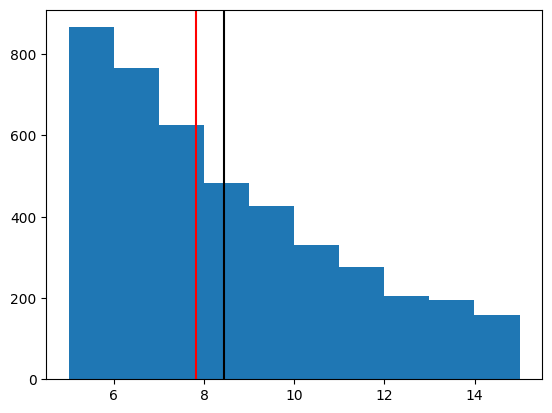

In [43]:
exp_dist=np.random.default_rng().exponential(5.0, 5000)+5

exp_dist=exp_dist[exp_dist<=15]

fig,ax=plt.subplots(1,1)
ax.hist(exp_dist)
ax.axvline(np.median(exp_dist),color='r')
ax.axvline(np.mean(exp_dist),color='k') 

In [28]:
np.sum(exp_dist[0:8])

59.74834887646564

In [52]:
time_bins=np.arange(0,70,0.1)

rando_tracker=0
current_context=0

random_block_info={
    'number of blocks':[],
    'task_duration':[],
    'average_block_length':[],
}

for ii in range(0,500):
    context_bins=np.full((len(time_bins)),fill_value=np.nan)
    total_time=0
    lengths=[]

    while total_time<55:
        rando_block_length=exp_dist[rando_tracker]
        context_bins[np.where(time_bins>total_time)[0][0]:np.where(time_bins>total_time+rando_block_length)[0][0]]=current_context

        total_time+=rando_block_length
        rando_tracker+=1

        if current_context==0:
            current_context=1
        elif current_context==1:
            current_context=0
        
        lengths.append(rando_block_length)

    
    random_block_info['number of blocks'].append(np.sum(np.abs(np.diff(context_bins[~np.isnan(context_bins)])))+1)
    random_block_info['task_duration'].append(total_time)
    random_block_info['average_block_length'].append(np.mean(lengths))

    # fig,ax=plt.subplots(1,1)
    # ax.plot(time_bins,context_bins)
    # ax.set_xlim(0,70)
    # ax.set_title('number of blocks='+str(np.sum(np.abs(np.diff(context_bins[~np.isnan(context_bins)])))+1)+
    #             '; task duration='+str(np.round(total_time,decimals=2))+
    #             '; average block length='+str(np.round(np.mean(lengths),decimals=2)))

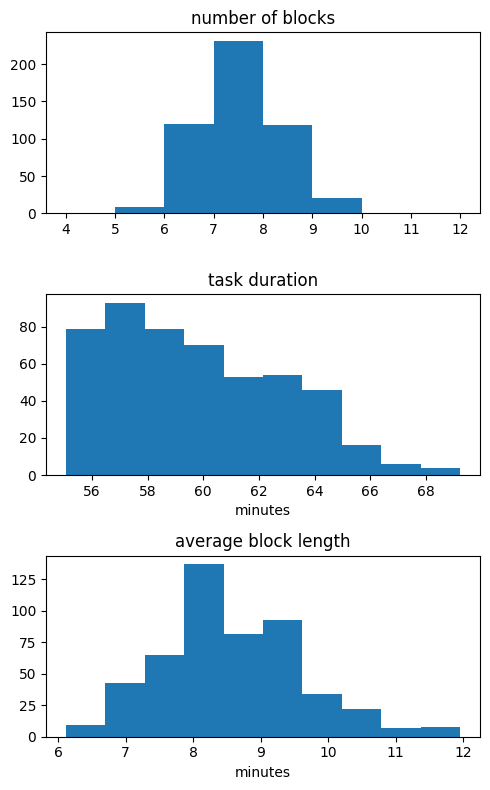

In [53]:
fig,ax=plt.subplots(3,1,figsize=(5,8))
ax[0].hist(random_block_info['number of blocks'],bins=np.arange(4,13,1))
ax[0].set_title('number of blocks')

ax[1].hist(random_block_info['task_duration'])
ax[1].set_title('task duration')
ax[1].set_xlabel('minutes')

ax[2].hist(random_block_info['average_block_length'])
ax[2].set_title('average block length')
ax[2].set_xlabel('minutes')

fig.tight_layout()

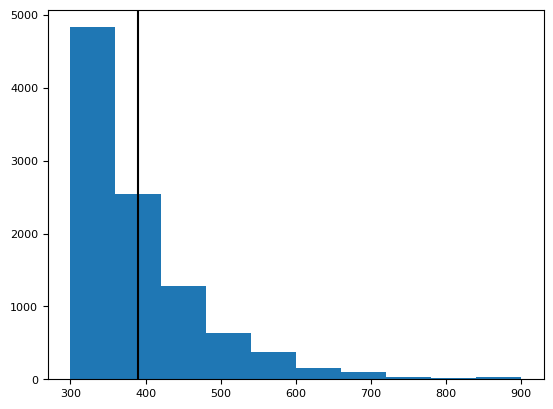

In [115]:
import random

expo_mean=90
expo_min=300
expo_max=900

n_repeats=10000

exp_dist=[]

for xx in range(0,n_repeats):
    exp_dist.append(random.expovariate(1/expo_mean)+expo_min)
exp_dist=np.array(exp_dist)

exp_dist[exp_dist>=expo_max]=expo_max
# exp_dist=exp_dist[exp_dist<=expo_max]

fig,ax=plt.subplots(1,1)
ax.hist(exp_dist)
# ax.axvline(np.median(exp_dist),color='r')
ax.axvline(np.mean(exp_dist),color='k') 

In [86]:
time_bins=np.arange(0,4500,1.0)

rando_tracker=0
current_context=0

random_block_info={
    'number of blocks':[],
    'task_duration':[],
    'average_block_length':[],
}

for ii in range(0,500):
    context_bins=np.full((len(time_bins)),fill_value=np.nan)
    total_time=0
    lengths=[]

    while total_time<=3600:
        rando_block_length=exp_dist[rando_tracker]
        context_bins[np.where(time_bins>total_time)[0][0]:np.where(time_bins>total_time+rando_block_length)[0][0]]=current_context

        total_time+=rando_block_length
        rando_tracker+=1

        if current_context==0:
            current_context=1
        elif current_context==1:
            current_context=0
        
        lengths.append(rando_block_length)

    
    random_block_info['number of blocks'].append(np.sum(np.abs(np.diff(context_bins[~np.isnan(context_bins)])))+1)
    random_block_info['task_duration'].append(total_time)
    random_block_info['average_block_length'].append(np.mean(lengths))

    # fig,ax=plt.subplots(1,1)
    # ax.plot(time_bins,context_bins)
    # ax.set_xlim(0,70)
    # ax.set_title('number of blocks='+str(np.sum(np.abs(np.diff(context_bins[~np.isnan(context_bins)])))+1)+
    #             '; task duration='+str(np.round(total_time,decimals=2))+
    #             '; average block length='+str(np.round(np.mean(lengths),decimals=2)))

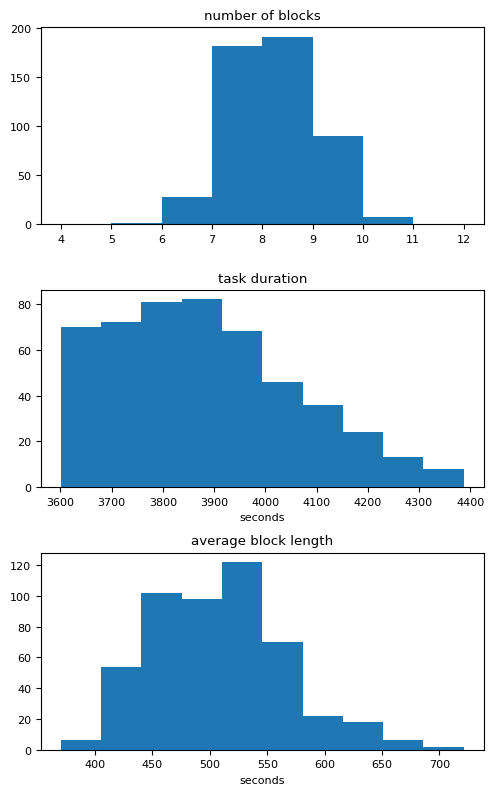

In [87]:
fig,ax=plt.subplots(3,1,figsize=(5,8))
ax[0].hist(random_block_info['number of blocks'],bins=np.arange(4,13,1))
ax[0].set_title('number of blocks')

ax[1].hist(random_block_info['task_duration'])
ax[1].set_title('task duration')
ax[1].set_xlabel('seconds')

ax[2].hist(random_block_info['average_block_length'])
ax[2].set_title('average block length')
ax[2].set_xlabel('seconds')

fig.tight_layout()

In [57]:
# np.sum(np.abs(np.diff(context_bins[~np.isnan(context_bins)])))+1

In [56]:
# np.where(time_bins>total_time)[0]

In [107]:
block_shuffle_type='exponential'
all_block_index_psuedo=[]
all_block_lengths_pseudo=[]
all_block_contexts_pseudo=[]

block_index_pseudo=[]
pred_var_pseudo=[]

for nn in range(0,n_block_repeats):
    current_context=np.random.choice([0,1],1,replace=False)
    fake_context=np.full(len(trials[:]), fill_value='nan')
    fake_block_nums=np.full(len(trials[:]), fill_value=np.nan)
    # =block_context
    total_time=0
    current_block_index=0
    block_lengths=[]
    block_contexts=[]
    block_index=[]

    while total_time<=3600:
        if block_shuffle_type=='exponential':
            rando_block_length=random.expovariate(1/exp_block_duration_mean)+exp_block_duration_min
        elif block_shuffle_type=='uniform':
            rando_block_length=random.uniform(exp_block_duration_min,exp_block_duration_max)
        if rando_block_length>exp_block_duration_max:
            rando_block_length=exp_block_duration_max

        if current_context==0:
            current_context=1
        elif current_context==1:
            current_context=0
        
        block_lengths.append(rando_block_length)
        block_contexts.append(current_context)
        block_index.append(current_block_index)
        total_time+=rando_block_length
        current_block_index+=1

    all_block_lengths_pseudo.append(np.hstack(block_lengths))
    all_block_contexts_pseudo.append(np.hstack(block_contexts))
    all_block_index_psuedo.append(np.hstack(block_index))

    #apply to trials
    for block in range(0,len(block_lengths)):
        block_start_time=start_time+np.sum(block_lengths[:block])
        if block_start_time<=trials[:]['start_time'].iloc[-1]:
            block_trials=trials[:].query('start_time>=@block_start_time').index
            fake_context[block_trials]=block_context_names[block_contexts[block]]
            fake_block_nums[block_trials]=block

    block_index_pseudo.append(fake_block_nums[trial_sel])
    pred_var_pseudo.append(fake_context[trial_sel])

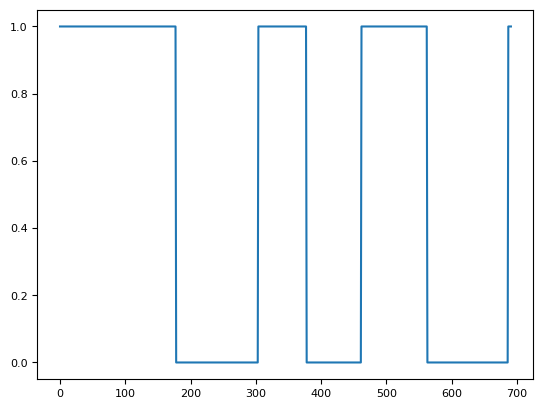

In [110]:
fig,ax=plt.subplots()
ax.plot(fake_context=='vis')